In [1]:
import os
import numpy as np
import pandas as pd
import random
import string
from itertools import groupby

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import cv2
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
train_csv = pd.read_csv('./dataset/written_name_train_v2.csv')
val_csv = pd.read_csv('./dataset/written_name_validation_v2.csv')
train_img_dir = './dataset/train_v2/train'
val_img_dir = './dataset/validation_v2/validation'
print(train_csv.shape[0], val_csv.shape[0])
train_csv.head(5)

330961 41370


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


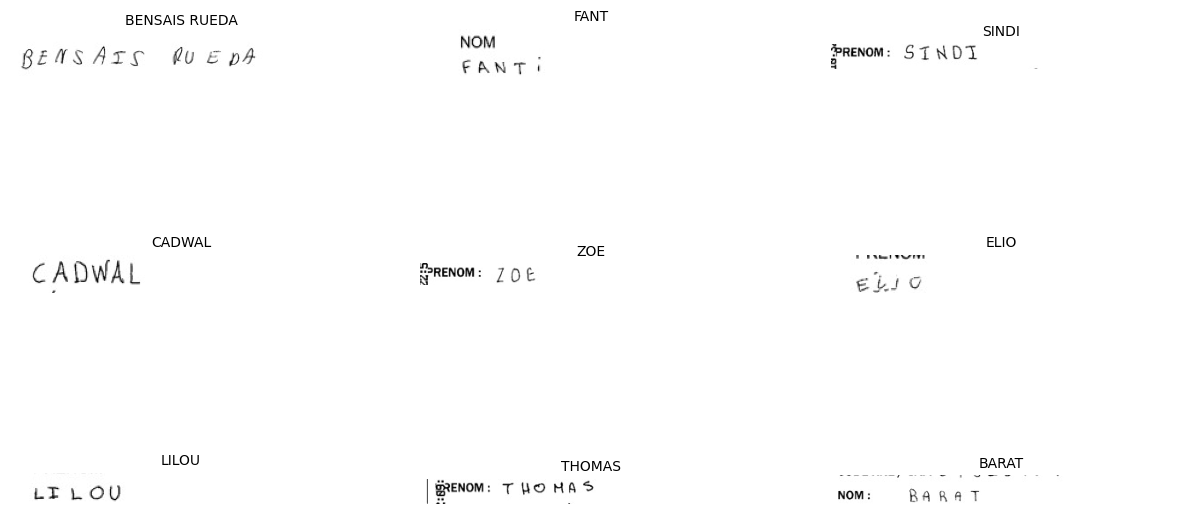

In [3]:
def visualization_data(data_csv, image_dir):
    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))
    
    # Loop over the random images and plot the bounding boxes
    for i in range(9):
        row = i // 3
        col = i % 3
        
        idx = random.randint(0, 1000)
        # Load the image
        image_path = os.path.join(image_dir, data_csv.loc[idx, 'FILENAME'])
        image = cv2.imread(image_path, 0)
        axs[row, col].imshow(image, cmap = 'gray')
        axs[row, col].set_title(data_csv.loc[idx, 'IDENTITY'], fontsize=10)
        axs[row, col].axis('off')
    plt.show()
    
visualization_data(train_csv, train_img_dir)

In [4]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
val_csv = val_csv[val_csv['IDENTITY'] != 'UNREADABLE']
print(train_csv.shape[0], val_csv.shape[0])

330859 41358


In [5]:
alphabets = string.ascii_uppercase + "' -"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64 # max length of predicted labels: 64
batch_size = 512

def encode_to_label(text):
    # Encoding each output word into digits
    dig_list = []
    for char in str(text):
        idx = alphabets.find(char)
        dig_list.append(idx if idx!=-1 else alphabets.find('-'))
    
    return pad_sequences([dig_list], maxlen=max_str_len, padding='post', value=-1)[0]

name = 'QUY DAU'
print(name, '\n', encode_to_label(name))


QUY DAU 
 [16 20 24 27  3  0 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [6]:
def decode_to_text(number_arr):
    text = ''
    for number in number_arr:
        if number == -1: # CTC blank
            break
        else:
            text += alphabets[number]

    return text

decode_to_text([16, 20, 24, 27, 3, 0, 20, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

'QUY DAU'

In [7]:
@tf.function
def preprocess_image(image_path, label, label_len):
    # Read image
    file = tf.io.read_file(image_path)
    # Decode and convert to grayscale
    image = tf.image.decode_png(file, channels=1)
    # Convert to float32 in [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image
    image = tf.image.resize(image, [64, 256])
    # Compute the input_len
    input_len = [num_of_timestamps - 2]
    
    return image, label, input_len, label_len, [0]


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Function for Create list of image data
def create_data_list(data_csv, img_dir):
    data_x, data_y, label_len = [], [], []
    for idx, row in data_csv.iterrows():
        if isinstance(row['IDENTITY'], str):
            data_x.append(os.path.join(img_dir, row['FILENAME']))
            text = row['IDENTITY'].upper()
            data_y.append(encode_to_label(text))
            label_len.append(len(text))
        
    return data_x, data_y, label_len

# Function for Create tensorflow dataset
def create_tf_dataset(data_x, data_y, label_len):
    dataset = tf.data.Dataset.from_tensor_slices((data_x, data_y, label_len))
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(batch_size)
    dataset = dataset.map(lambda *x: (x[0:-1],x[-1])).prefetch(AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [9]:
# Create tensorflow Dataset for train data
train_x, train_y, train_label_len = create_data_list(train_csv, train_img_dir)
train_dataset = create_tf_dataset(train_x, train_y, train_label_len)

# Create tensorflow Dataset for val data
val_x, val_y, val_label_len = create_data_list(val_csv, val_img_dir)
val_dataset = create_tf_dataset(val_x, val_y, val_label_len)

print(len(train_y), len(val_y))


330294 41280


In [10]:
# Defining the CTC loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [11]:
# Define the Convolutional Block
def conv_block(num_filters, use_max_pool=True, pool_size=(4, 2), stride=2):
    cnn = Sequential()
    cnn.add(Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D(pool_size=pool_size, strides=stride))
    return cnn
    
# Define the CRNN Model
def CRNN():
    # Inputs
    inputs = Input(shape=(64, 256, 1), name='image')
    labels = Input(name="label", shape=(None,), dtype="float32")
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    # CNN
    conv1 = conv_block(32)(inputs)
    conv2 = conv_block(64)(conv1)
    conv3 = conv_block(128, pool_size=(4, 1), stride=1)(conv2)
    conv4 = conv_block(256, pool_size=(4, 1), stride=1)(conv3)
    conv5 = conv_block(128, pool_size=(5, 1), stride=1)(conv4)
    
    # CNN --> RNN
    reshape = Reshape((num_of_timestamps, 512))(conv5)
    dense = Dense(num_of_timestamps, activation='relu')(reshape)
    bn = BatchNormalization()(dense)
    dropout = Dropout(0.2)(bn)
    
    # RNN
    lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(dropout)
    lstm2 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(lstm1)
    
    # Outputs
    y_pred = Dense(num_of_characters, activation = 'softmax')(lstm2)
    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    
    pred_model = Model(inputs=inputs, outputs=y_pred)
    train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=ctc_loss)
    
    return pred_model, train_model

model, train_model = CRNN()
train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential (Sequential)        (None, 31, 128, 32)  448         ['image[0][0]']                  
                                                                                                  
 sequential_1 (Sequential)      (None, 14, 64, 64)   18752       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 11, 64, 128)  74368       ['sequential_1[0][0]']     

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load an image
img = cv2.imread('Major P\Adobe Scan 20-Sep-2023_1 (1).jpg')

# Define your own polygon (or in this case, rectangle for cropping)
# The format is [y1:y2, x1:x2]
x1, y1, x2, y2 = 1033, 707, 1294, 793

# Crop the image using the coordinates
roi = img[y1:y2, x1:x2]


# Save the ROI to a temporary file
cv2.imwrite('temp_roi.jpg', roi)

# Here you can feed the roi to your function
letter,image = get_letters('temp_roi.jpg')
word = get_word(letter)
print(word)
plt.imshow(image)

# Optional: Delete the temporary file after use
import os
os.remove('temp_roi.jpg')

In [13]:
# Compile the model
train_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
                    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0))

filepath = "./model/best_model.h5"

# function callback
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor= 'val_loss',
                             verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

earlyStopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
callbacks_list = [checkpoint, earlyStopping]
history = train_model.fit(train_dataset.batch(8),  # replace new_batch_size with a smaller number
                          epochs=30,
                          validation_data=val_dataset,
                          verbose = 1,
                          shuffle=True, 
                          callbacks=callbacks_list)

# Save the model
model.save('./model/my_model.h5')

Epoch 1/30


ValueError: in user code:

    File "c:\Users\Tanuj\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Tanuj\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Tanuj\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Tanuj\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Tanuj\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Tanuj\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 64, 256, 1), found shape=(None, None, 64, 256, 1)
